In [5]:
####################################################################################################
# CR.GrobsCompare.ipynb
# Karl Lapo July/2015
####################################################################################################
# Creates movie of daily irradiances
####################################################################################################

# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

## Import statements
# netcdf/numpy/xray
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xray

# OS interaction
import sys, pickle, os

# import subplots function for plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap

# Movies!
from moviepy.editor import *

## Directory listing
dir_data = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/data'
dir_print = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/Graphics'

# List of sub-directory names for each data set
dir_NLDAS = '/NLDAS'
dir_SYN = '/CERES_SYN'
dir_grobs = '/GroundObs'
dir_VIC = '/VIC_MTCLIM'
dir_WRF = '/WRF'

# Directory for basemap pickle files
dir_bmap = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/data/basemap'

Imageio: 'libfreeimage-3.16.0-osx10.6.dylib' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/freeimage/libfreeimage-3.16.0-osx10.6.dylib (4.3 MB)
Downloading: 8192/4461680 bytes (0.2%)81920/4461680 bytes (1.8%)196608/4461680 bytes (4.4%)311296/4461680 bytes (7.0%)442368/4461680 bytes (9.9%)589824/4461680 bytes (13.2%)720896/4461680 bytes (16.2%)868352/4461680 bytes (19.5%)1048576/4461680 bytes (23.5%)1228800/4461680 bytes (27.5%)1425408/4461680 bytes (31.9%)1638400/4461680 bytes (36.7%)1851392/4461680 bytes (41.5%)2097152/4461680 bytes (47.0%)

In [2]:
####################################################################################################
# Functions
####################################################################################################

In [3]:
##### Discrete colorbar -- from Joe Hamman (https://github.com/jhamman/tonic/blob/master/tonic/plot_utils.py#L66-L94)
def cmap_discretize(cmap, n_colors=10):
    """Return discretized colormap.
    Parameters
    ----------
    cmap : str or colormap object
        Colormap to discretize.
    n_colors : int
        Number of discrete colors to divide `cmap` into.
    Returns
    ----------
    disc_cmap : LinearSegmentedColormap
        Discretized colormap.
    """
    try:
        cmap = cm.get_cmap(cmap)
    except:
        cmap = cm.get_cmap(eval(cmap))
    colors_i = np.concatenate((np.linspace(0, 1., n_colors), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., n_colors + 1)
    cdict = {}
    for ki, key in enumerate(('red', 'green', 'blue')):
        cdict[key] = [(indices[i], colors_rgba[i - 1, ki], colors_rgba[i, ki])
                      for i in range(n_colors + 1)]

    return matplotlib.colors.LinearSegmentedColormap(cmap.name + "_%d" % n_colors,
                                              cdict, 1024)

In [4]:
##### Basemap
def build_basemap(lon,lat,dir_bmap,bmap_name='basemap.pickle',rewrite=False):
    # Lat/Lon handling - map extent
    bmap_dict = {}
    bmap_dict['lat_i'] = np.min(lat)
    bmap_dict['lon_i'] = np.min(lon)
    bmap_dict['lat_j'] = np.max(lat)
    bmap_dict['lon_j'] = np.max(lon)
    
    bmap_dict['lat_mid'] = lat[np.round(lat.size/2)]
    bmap_dict['lon_mid'] = lon[np.round(lon.size/2)]
    
    bmap_dict['lat_labels'] = np.arange(np.round(bmap_dict['lat_i']), np.round(bmap_dict['lat_j']), 2)
    bmap_dict['lon_labels'] = np.arange(np.round(bmap_dict['lon_i']), np.round(bmap_dict['lon_j']), 2)
    
    os.chdir(dir_bmap)
    # Force rewriting basemap pickle file
    if rewrite:
        bmap = Basemap(llcrnrlon=bmap_dict['lon_i'],llcrnrlat=bmap_dict['lat_i'],\
                        urcrnrlon=bmap_dict['lon_j'],urcrnrlat=bmap_dict['lat_j'],\
                        rsphere=(6378137.00,6356752.3142),resolution='l',area_thresh=1000.,projection='lcc',\
                        lat_1=bmap_dict['lat_mid'],lon_0=bmap_dict['lon_mid'])
        pickle.dump(bmap,open(bmap_name,'wb'),-1)
    
    else:
        try:
            bmap = pickle.load(open(bmap_name,'rb'))
        except IOError as e:
            bmap = Basemap(llcrnrlon=bmap_dict['lon_i'],llcrnrlat=bmap_dict['lat_i'],\
                            urcrnrlon=bmap_dict['lon_j'],urcrnrlat=bmap_dict['lat_j'],\
                            rsphere=(6378137.00,6356752.3142),resolution='l',area_thresh=1000.,projection='lcc',\
                            lat_1=bmap_dict['lat_mid'],lon_0=bmap_dict['lon_mid'])
            pickle.dump(bmap,open(bmap_name,'wb'),-1)
    
    return bmap,bmap_dict

In [42]:
####################################
## Read previously processed data ##
####################################
# ///// See CC.CA.StatisticsMaps.Master for details on creation of xray data 

##### Load daily data

###########
## NLDAS ##
os.chdir(dir_data+dir_NLDAS)
nldas = xray.open_dataset('CA.NLDAS.irrad.daily.nc')
nldas = nldas.rename({'DLWRF_110_SFC':'LWdwn','DSWRF_110_SFC':'SWdwn'})
nldas.SWdwn.values[nldas.SWdwn.values > 2000] = np.nan

#########
## SYN ##
os.chdir(dir_data+dir_SYN)
syn = xray.open_dataset('CA.syn.irrad.daily.nc')
syn.longitude.values = syn.longitude.values-360
syn.latitude.values = syn.latitude.values[::-1]
for d in np.arange(syn.time.size):
    syn.SWdwn.values[d-1,:,:] = np.flipud(syn.SWdwn.values[d-1,:,:])
    syn.LWdwn.values[d-1,:,:] = np.flipud(syn.LWdwn.values[d-1,:,:])

#########
## VIC ##
os.chdir(dir_data+dir_VIC)
mtclim = xray.open_dataset('CA.MTCLIM.irrad.daily.nc')

#########
## WRF ##
os.chdir(dir_data+dir_WRF)
wrf = xray.open_dataset('CA.WRF.irrad.daily.nc')
wrf = wrf.rename({'lon':'longitude','lat':'latitude'})

In [43]:
##### Process daily ground observations
os.chdir(dir_data+dir_grobs)
grobs = xray.open_dataset('CA.grobs_combined.daily.xray.nc')
grobs = grobs.resample(freq='D', dim='time', how='mean')
grobs.SWdwn.values[grobs.SWdwn.values == 0] = np.nan
grobs = grobs.rename({'lon':'longitude','lat':'latitude'})
grobs.longitude.values = -grobs.longitude.values

## Remove stations outside study domain
# Bounding box - ragged domain
LL_rag = [-120,34.5]
LR_rag = [-115,34.5]
UR_rag = [-118.5,41]
UL_rag = [-123.5,41]

# Station lat/lon
stat_lat = grobs.latitude.values
stat_lon = grobs.longitude.values

# Ragged domain, CA study area
line_west_m = (UL_rag[1]-LL_rag[1])/(UL_rag[0]-LL_rag[0])
line_west_b = LL_rag[1]-line_west_m*LL_rag[0]
line_east_m = (UR_rag[1]-LR_rag[1])/(UR_rag[0]-LR_rag[0])
line_east_b = LR_rag[1]-line_east_m*LR_rag[0]
ind = np.nonzero((stat_lon > (stat_lat -line_west_b)/line_west_m) & \
                (stat_lon < (stat_lat-line_east_b)/line_east_m) & \
                (stat_lat > LR_rag[1]) & (stat_lat < UL_rag[1]))
# Reindex
stat_to_keep = grobs.station[ind]
grobs = grobs.reindex(station=stat_to_keep)

## Append station group information
# Station data excel speadsheet
stdat = pd.read_csv('All_StationSummary.v2.csv',sep= ',', \
                index_col=0,na_values=[-9999,'NaN']) # Read the supporting information
# station data -> xray structure
stdat = xray.Dataset(coords={'station': (['station'], stdat.index), \
                             'Grouping': (['station'],  stdat.Grouping)})    
# Merge into ground observation structure
grobs = grobs.merge(stdat,join='inner')

In [44]:
#### Combine
## List w/ all irradiance datasets
daily_mean = {}
daily_mean['syn'] = syn
daily_mean['nldas'] = nldas
daily_mean['mtclim'] = mtclim
daily_mean['wrf'] = wrf
daily_mean['grobs'] = grobs

# Product names
pr_names = ['mtclim','nldas','syn','wrf']
num_products = np.size(pr_names)

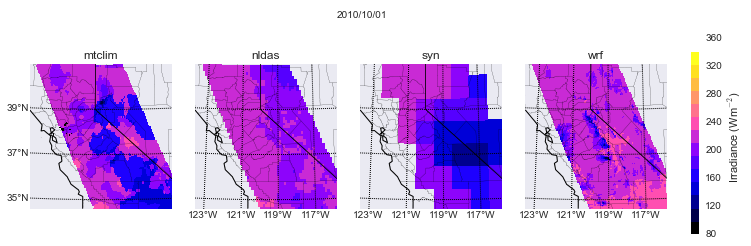

In [114]:
#########################
# Daily Mean Shortwave ##
#########################
SWmin = 80
SWmax = 360
dSW = 20
cmap = cmap_discretize(cm.gnuplot2,15)

# Build basemap
lat = daily_mean['mtclim'].latitude.values
lon = daily_mean['mtclim'].longitude.values

bmp,bmd = build_basemap(lon,lat,dir_bmap,'CA.Domain.bmp.pickle',rewrite=True)
lat_labels = bmd['lat_labels']
lon_labels = bmd['lon_labels']


fig = plt.figure(figsize=(12,4))
gs = matplotlib.gridspec.GridSpec(2,num_products+1,width_ratios=np.append(np.ones(num_products)*16,np.array(1.)),\
                                 height_ratios=[1,30])
im = {}
txt = None
# Draw basemap on each image
d = pd.date_range(start='2005-10-01',freq='D',periods=1)
for ind,pr in enumerate(pr_names):
    ax = plt.subplot(gs[1,ind])
    ax.set_title((pr))
    lon_rad,lat_rad = np.meshgrid(daily_mean[pr].longitude.values,daily_mean[pr].latitude.values)
    if daily_mean[pr].SWdwn.loc[d[0]:d[0]].any():
        SW_for_plot = np.squeeze(daily_mean[pr].SWdwn.loc[d[0]:d[0]].values)
        SW_for_plot = np.ma.masked_where(np.isnan(SW_for_plot),SW_for_plot)
        im[ind] = bmp.pcolormesh(lon_rad,lat_rad,SW_for_plot,\
                    cmap=cmap,vmin=SWmin,vmax=SWmax,shading='flat',latlon=True)
    
    ## Format
    if ind == 0:
        bmp.drawparallels(lat_labels,labels=[1,0,0,0])
    else:
        bmp.drawparallels(lat_labels)
        bmp.drawmeridians(lon_labels,labels=[0,0,0,1]) 

    # political boundaries.
    bmp.drawstates()
    bmp.drawcoastlines()
    bmp.drawcounties()

# Colorbar
caxi=plt.subplot(gs[1,-1])
cbar = plt.colorbar(im[0], cax=caxi, orientation = "vertical",\
                    ticks=np.arange(SWmin,SWmax+dSW,dSW*2),spacing='proportional')
cbar.ax.set_ylabel(('Irradiance (Wm$^{-2}$)'))
fig.tight_layout
    
for d in pd.date_range(start='2004-10-01',end='2010-10-01',freq='d'):     
    for ind,pr in enumerate(pr_names):
        ## Monthly value for each product
        ax = plt.subplot(gs[1,ind])
        # Lat/Lon handling - product coords
        lon_rad,lat_rad = np.meshgrid(daily_mean[pr].longitude.values,daily_mean[pr].latitude.values)
        if daily_mean[pr].SWdwn.loc[d:d].any():
            SW_for_plot = np.squeeze(daily_mean[pr].SWdwn.loc[d:d].values)
            SW_for_plot = np.ma.masked_where(np.isnan(SW_for_plot),SW_for_plot)
            im[ind].set_array(SW_for_plot[:-1,:-1].ravel())
            plt.draw()
        else:
            SW_for_plot = np.squeeze(daily_mean[pr].SWdwn.loc[d:d].values)
            im[ind].set_array(np.ones_like(SW_for_plot[:-1,:-1].ravel())*np.nan)
            plt.draw()

            
    # Date
    ax = plt.subplot(gs[0,1])
    if txt:
        txt.remove()
    txt = ax.text(1,0,pd.to_datetime(d).strftime('%Y/%m/%d'))
    ax.axis('off');
    
    # Output
    os.chdir(dir_print+'/DailyProduct')
    outdate = pd.to_datetime(d).strftime('%Y_%m_%d')
    fname = 'Qsi.daily.'+outdate+'.png'
    fig.savefig(fname)
#     plt.close(fig)


In [53]:
## Read pngs, assign each one to a movie frame
os.chdir(dir_print+'/DailyProduct')

# List of April images
content = os.listdir(os.getcwd())
clip_dict = {}
for yyyy in np.arange(2005,2009):
    fname = 'Qsi.daily.'+str(yyyy)
    png_list = []
    for files in content:
        if files[:len(fname)] == fname and files.split('.')[2].split('_')[1] == '04':
            png_list.append(files)
    clip_dict[yyyy] = ImageSequenceClip(png_list,fps=4)
    clip_dict[yyyy].resize(.6)
    
combined_clip = clips_array([[clip_dict[2005]],\
                             [clip_dict[2006]],\
                             [clip_dict[2007]],\
                             [clip_dict[2008]]])
combined_clip.resize(height=480)
combined_clip.write_videofile("Test_April.mp4")

[MoviePy] >>>> Building video Test_April.mp4
[MoviePy] Writing video Test_April.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: Test_April.mp4 

